In [33]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset

from sklearn.metrics import mean_squared_error

In [2]:
from transformers import Trainer, TrainingArguments
from transformers import BertForSequenceClassification, BertTokenizer

### Define a Pre-Trained Model and Tokenizer

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

#Model Name
pretrained_model = "microsoft/MiniLM-L12-H384-uncased"

tokenizer = BertTokenizer.from_pretrained(pretrained_model)
model = BertForSequenceClassification.from_pretrained(pretrained_model, num_labels=1).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data

In [4]:
#Read each file
tr = pd.read_csv('si630w22-hw3-train.csv')
de = pd.read_csv('si630w22-hw3-dev.csv')
te = pd.read_csv('si630w22-hw3-test.public.csv')
og = pd.read_csv('si630w22-hw3-data.csv')

#Concatenate question and reply into a single string
og['concat'] = og['question_text'] + ' [SEP] ' + og['reply_text']

#Add concat to each dataset, merged on question ID
train = tr.merge(og, left_on='id', right_on='question_id')
dev   = de.merge(og, left_on='id', right_on='question_id')

#Groupby concat, then group in order to filter out groups later
train = train.groupby(by=['concat', 'group']).mean().reset_index()
dev   = dev.groupby(by=['concat', 'group']).mean().reset_index()

#Get all unique groups
group_list = list(set(list(train['group'])))

In [5]:
def create_training_datasets(df, group_list=group_list):
    dfs = {}

    for g in group_list:
        temp = df[df['group'] != str(g)]
        temp = temp.groupby(by=['concat']).mean().reset_index()
        dfs[g] = [temp]

    return dfs

def create_dev_datasets(df, group_list=group_list):
    big_d = {}

    for g in group_list:
        df_copy = df.copy()
        b_c_qs = set(df_copy[df_copy['group'] == str(g)]['concat'])
        a_qs = set(df_copy[df_copy['group'] != str(g)]['concat']) - b_c_qs

        df_copy['dev_group'] = np.where(df_copy['concat'].isin(a_qs), 'a', np.where(df_copy['group'] == str(g), 'b', 'c'))

        df_a = df_copy[df_copy['dev_group'] == 'a'].groupby(by=['concat']).mean().reset_index()
        df_b = df_copy[df_copy['dev_group'] == 'b'].groupby(by=['concat']).mean().reset_index()
        df_c = df_copy[df_copy['dev_group'] == 'c'].groupby(by=['concat']).mean().reset_index()

        big_d[g] = [df_a, df_b, df_c]

    return big_d

train_datasets = create_training_datasets(train)
dev_datasets = create_dev_datasets(dev)

In [6]:
print(len(train_datasets))
print(len(dev_datasets))

24
24


In [7]:
class Data(Dataset):
    def __init__(self, features, labels=None):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        item = {key: torch.tensor(val[index]) for key, val in self.X.items()}
        if self.y:
            item['labels'] = torch.tensor(self.y[index])
        return item

    def __len__(self):
        return len(self.X['input_ids'])

### Training


In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}  

In [12]:
args = TrainingArguments(
    seed=0,

    #Training Loss
    save_strategy = "steps",
    logging_strategy = 'steps',
    logging_steps = 50,

    #Model Details
    learning_rate=1e-5,
    per_device_train_batch_size=1,
    num_train_epochs=5,
    report_to="none",
    weight_decay=0.01,
    output_dir='si630/outputs'
)

PyTorch: setting up devices


In [14]:
results = {}

for group in tqdm(group_list):

    #Instatitate Training Dataset
    training_df = train_datasets[group][0]
    train_X = list(training_df['concat'])[:30]
    train_y = list(training_df['rating'])[:30]

    #Create Training Data object
    X_train_tokenized = tokenizer(train_X, padding=True, truncation=True, max_length=512)
    train_data = Data(X_train_tokenized, train_y)

    #Training
    trainer = Trainer(
        model, 
        args,
        train_dataset=train_data,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )
    trainer.train()

    #Extract Dev Dataframe List
    devs = dev_datasets[group]

    dev_results = []

    for d in devs:

        #Access Dataset and Create Data Object
        dev_X = list(d['concat'])[:30]
        dev_y = list(d['rating'])[:30]
        X_dev_tokenized = tokenizer(dev_X, padding=True, truncation=True, max_length=512)
        dev_data = Data(X_dev_tokenized)

        test_trainer = Trainer(model)
        raw_pred, _, _ = test_trainer.predict(dev_data)

        pred = raw_pred.flatten().tolist()
        result = np.corrcoef(pred, dev_y)[0][1]

        #Append Results to Dev Results
        dev_results.append(result)    

    results[group] = dev_results

# results

  0%|          | 0/24 [00:00<?, ?it/s]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,4.764900
100,3.806500
150,3.416100




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


  4%|▍         | 1/24 [00:07<02:44,  7.17s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,2.562300
100,2.036200
150,1.814200




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


  8%|▊         | 2/24 [00:14<02:38,  7.19s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,1.293500
100,1.006700
150,1.037900




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 12%|█▎        | 3/24 [00:21<02:30,  7.15s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.853600
100,0.742200
150,0.842400




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 17%|█▋        | 4/24 [00:28<02:22,  7.10s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.626000
100,0.603800
150,0.591700




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 21%|██        | 5/24 [00:35<02:15,  7.13s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.430500
100,0.241100
150,0.206700




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 25%|██▌       | 6/24 [00:42<02:08,  7.14s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.247000
100,0.204700
150,0.183200




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 29%|██▉       | 7/24 [00:49<02:01,  7.14s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.143400
100,0.107100
150,0.090800




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 33%|███▎      | 8/24 [00:57<01:54,  7.16s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.167800
100,0.156600
150,0.122900




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 38%|███▊      | 9/24 [01:04<01:46,  7.11s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.131300
100,0.098000
150,0.082100




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 42%|████▏     | 10/24 [01:11<01:39,  7.13s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.081000
100,0.070200
150,0.054200




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 46%|████▌     | 11/24 [01:18<01:32,  7.14s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.102300
100,0.066100
150,0.052600




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 50%|█████     | 12/24 [01:25<01:25,  7.14s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.053800
100,0.028500
150,0.029600




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 54%|█████▍    | 13/24 [01:32<01:18,  7.16s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.039100
100,0.037200
150,0.027900




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 58%|█████▊    | 14/24 [01:39<01:11,  7.11s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.053000
100,0.037300
150,0.028400




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 62%|██████▎   | 15/24 [01:47<01:04,  7.13s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.045800
100,0.028700
150,0.027300




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 67%|██████▋   | 16/24 [01:54<00:57,  7.13s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.042700
100,0.037900
150,0.038800




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 71%|███████   | 17/24 [02:01<00:50,  7.18s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.062500
100,0.037000
150,0.032100




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 75%|███████▌  | 18/24 [02:08<00:43,  7.17s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.084500
100,0.071500
150,0.050700




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 79%|███████▉  | 19/24 [02:15<00:35,  7.17s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.031400
100,0.029500
150,0.017800




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 83%|████████▎ | 20/24 [02:22<00:28,  7.18s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.054100
100,0.031100
150,0.037700




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 88%|████████▊ | 21/24 [02:30<00:21,  7.18s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.076800
100,0.042500
150,0.042000




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 92%|█████████▏| 22/24 [02:37<00:14,  7.19s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.030500
100,0.036100
150,0.015800




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


 96%|█████████▌| 23/24 [02:44<00:07,  7.18s/it]***** Running training *****
  Num examples = 30
  Num Epochs = 5
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 150


Step,Training Loss
50,0.020600
100,0.017200
150,0.015900




Training completed. Do not forget to share your model on huggingface.co/models =)


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 30
  Batch size = 8


100%|██████████| 24/24 [02:51<00:00,  7.15s/it]


{'group_20': [0.06907404371931654, 0.4332600099249546, 0.5256558744673582],
 'group_21': [0.29731826806609196, 0.6071190380906176, 0.4049889822881483],
 'group_14': [0.40252077876582126, 0.4212079432518412, 0.44394178991692174],
 'group_22': [0.48376411406068287, 0.5381695558151413, 0.124938940325771],
 'group_07': [0.49609920088727594, 0.538238605376545, 0.36717126545573675],
 'group_05': [0.43333002218781586, 0.6008810182892952, 0.29042613420841795],
 'group_04': [0.4971769479869075, 0.816323674834387, 0.3711867639712817],
 'group_17': [0.49468405471389515, 0.49267579958904983, 0.6610929062039362],
 'group_13': [0.4740373257721286, 0.3844450864006932, 0.4682746269711147],
 'group_24': [0.4609473482631572, 0.6894700369790019, 0.7812997079115153],
 'group_23': [0.5494206691578681, 0.5097213740544277, 0.44195927261398577],
 'group_19': [0.45272536736495583, 0.7789102770393607, 0.5242697663263433],
 'group_08': [0.505630233417919, 0.27824244443469975, 0.7320264029576365],
 'group_15': [0

### Display Results

In [15]:
results

{'group_20': [0.06907404371931654, 0.4332600099249546, 0.5256558744673582],
 'group_21': [0.29731826806609196, 0.6071190380906176, 0.4049889822881483],
 'group_14': [0.40252077876582126, 0.4212079432518412, 0.44394178991692174],
 'group_22': [0.48376411406068287, 0.5381695558151413, 0.124938940325771],
 'group_07': [0.49609920088727594, 0.538238605376545, 0.36717126545573675],
 'group_05': [0.43333002218781586, 0.6008810182892952, 0.29042613420841795],
 'group_04': [0.4971769479869075, 0.816323674834387, 0.3711867639712817],
 'group_17': [0.49468405471389515, 0.49267579958904983, 0.6610929062039362],
 'group_13': [0.4740373257721286, 0.3844450864006932, 0.4682746269711147],
 'group_24': [0.4609473482631572, 0.6894700369790019, 0.7812997079115153],
 'group_23': [0.5494206691578681, 0.5097213740544277, 0.44195927261398577],
 'group_19': [0.45272536736495583, 0.7789102770393607, 0.5242697663263433],
 'group_08': [0.505630233417919, 0.27824244443469975, 0.7320264029576365],
 'group_15': [0

In [20]:
characters = [
    '00', '01', '02', '03', '04', '05', '06', '07', '09',
    '10', '11', '12', '13', '14', '15', '16', '17', '19',
    '20', '21', '22', '23', '24',
]

sorted_results = {}

for c in characters:
    string = f"group_{c}"
    if string in results.keys():
        sorted_results[string] = results[string]
    else:
        continue

sorted_results

{'group_01': [0.3655555398023203, 0.7938995434568833, 0.6895539855174312],
 'group_02': [0.46267999420339034, 0.5580065982275412, 0.5943805998572814],
 'group_03': [0.5758278171738312, 0.24629315274573096, 0.4783586722642391],
 'group_04': [0.4971769479869075, 0.816323674834387, 0.3711867639712817],
 'group_05': [0.43333002218781586, 0.6008810182892952, 0.29042613420841795],
 'group_07': [0.49609920088727594, 0.538238605376545, 0.36717126545573675],
 'group_09': [0.37703221335930936, 0.7338387341367436, 0.6653321363935969],
 'group_10': [0.49931199358452694, -0.07687207927340887, 0.3525132835711374],
 'group_11': [0.42195813910530383, 0.7144167918366225, 0.714588428330336],
 'group_12': [0.5486824830525447, 0.5536702730045368, 0.4863619101747313],
 'group_13': [0.4740373257721286, 0.3844450864006932, 0.4682746269711147],
 'group_14': [0.40252077876582126, 0.4212079432518412, 0.44394178991692174],
 'group_15': [0.4790241611754698, 0.5027871619637944, 0.3132510823803858],
 'group_16': [0

In [31]:
df = pd.DataFrame(
    sorted_results,
    columns=sorted_results.keys()
).T

df.reset_index(inplace=True)
df.columns = ['group', 'a', 'b', 'c']
df

melted = pd.melt(df, id_vars='group', var_name="set", value_name="performance")
melted

,group,set,performance
0,group_01,a,0.365556
1,group_02,a,0.462680
2,group_03,a,0.575828
3,group_04,a,0.497177
4,group_05,a,0.433330
...,...,...,...
58,group_20,c,0.525656
59,group_21,c,0.404989
60,group_22,c,0.124939
61,group_23,c,0.441959


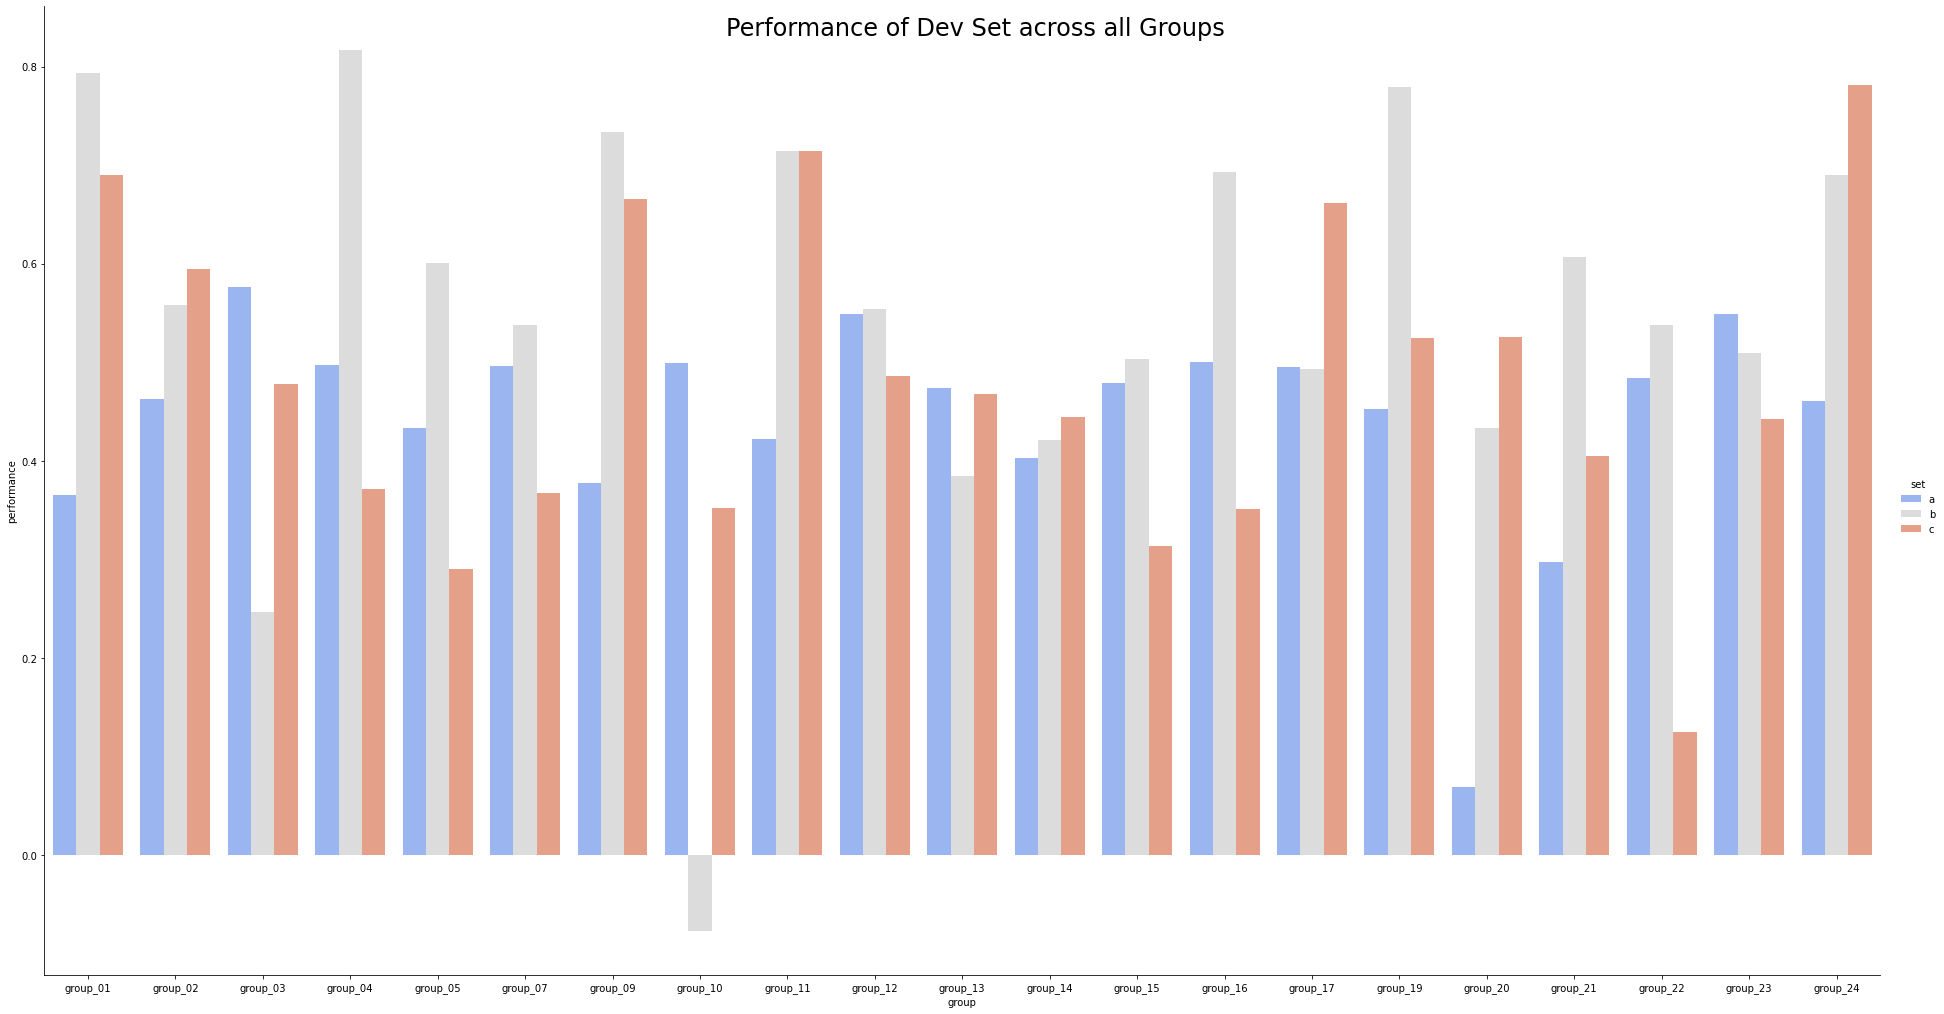

In [58]:
# plt.figure(figsize = (15,15))

plot = sns.catplot(
    data=melted,
    x='group',
    y='performance',
    hue='set',
    kind='bar',
    height=14,
    aspect=15/8,
    palette='coolwarm',
#     col_wrap=4
)

plot.fig.suptitle('Performance of Dev Set across all Groups', fontsize=24)
plt.show()

### Analysis of Annotation Evaluations

The visualization above displays the model's performance on each of the three development sets for each group.

The first general pattern to emerge is that set b consistently outperformed other sets across most groups. Set b was the items for which the annotators of a group annotated themselves, so this pattern confirms that model performance largely increases for every group when they're data is used. This is not true for every group, however. Group 10 observes a performance decrease when using their own annotations. Upon reviewing their annotation guidelines, there's nothing that suggests their scale of analysis is skewed relative to other groups (i.e. they assess quantity, hostility, thoughtfulness). Another possible cause for their outlier-ness is an unlucky pairing of questions for that specific development set. Each development set b is small compared to the total list of questions, and as each group can only cover ~450 questions, the overlapping groups can create a small sample for testing. It's likely that a test set will not accurate reflect the model or the performance of an annotator on occasion. 

Another observable pattern is how the labels of some groups better reflect the overall performance of the model. This can be seen by comparing set a and b for a given group. Group 12, 14, and 15 are examples of groups whose own performance closely mirror the entire annotator performance. 